In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
# import 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import keras
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, concatenate, Flatten
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
train_dir = os.path.join('../Data/train')
trainB_dir = os.path.join('../Data/trainB')
testA_dir = os.path.join('../Data/testA')
testB_dir = os.path.join('../Data/testB')
categories = ['no_tpo', 'tpo']

In [3]:
for category in categories:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

no_tpo 9265 images
tpo 10260 images


In [4]:
for category in categories:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(trainB_dir, category)))))

no_tpo 9265 images
tpo 10260 images


In [5]:
train = []
for category_id, category in enumerate(categories):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
# train = train.sort_values(['file']).reset_index(drop=True)
train.shape

(19525, 3)

In [6]:
train.head()

,file,category_id,category
0,train/no_tpo/Lambeth_no (295).tif,0,no_tpo
1,train/no_tpo/Lambeth_no (1690).tif,0,no_tpo
2,train/no_tpo/Barnet_no (1941).tif,0,no_tpo
3,train/no_tpo/Barnet_no (130).tif,0,no_tpo
4,train/no_tpo/Lambeth_no (1803).tif,0,no_tpo


In [7]:
trainB = []
for category_id, category in enumerate(categories):
    for file in os.listdir(os.path.join(trainB_dir,category)):
        trainB.append(['trainB/{}/{}'.format(category,file), category_id, category])
trainB=pd.DataFrame(trainB, columns=['file','category_id','category'])
# trainB = trainB.sort_values(['file']).reset_index(drop=True)
trainB.shape

(19525, 3)

In [8]:
trainB.head()

,file,category_id,category
0,trainB/no_tpo/Lambeth_no (295).tif,0,no_tpo
1,trainB/no_tpo/Lambeth_no (1690).tif,0,no_tpo
2,trainB/no_tpo/Barnet_no (1941).tif,0,no_tpo
3,trainB/no_tpo/Barnet_no (130).tif,0,no_tpo
4,trainB/no_tpo/Lambeth_no (1803).tif,0,no_tpo


In [9]:
testA = []
for category_id, category in enumerate(categories):
    for file in os.listdir(os.path.join(testA_dir, category)):
        testA.append(['testA/{}/{}'.format(category, file), category_id, category])
testA = pd.DataFrame(testA,columns = ['filepath', 'category_id','category'])
# testA = testA.sort_values(['filepath']).reset_index(drop=True)
testA.shape

(12797, 3)

In [10]:
testA.head()

,filepath,category_id,category
0,testA/no_tpo/non (4845).tif,0,no_tpo
1,testA/no_tpo/non (3894).tif,0,no_tpo
2,testA/no_tpo/non (3962).tif,0,no_tpo
3,testA/no_tpo/non (277).tif,0,no_tpo
4,testA/no_tpo/non (1891).tif,0,no_tpo


In [11]:
testB=[]
for category_id, category in enumerate(categories):
    for file in os.listdir(os.path.join(testB_dir,category)):
        testB.append(['testB/{}/{}'.format(category,file),category_id, category])
testB = pd.DataFrame(testB, columns=['filepath','category_id','category'])
# testB = testB.sort_values(['filepath']).reset_index(drop=True)
testB.shape

(12797, 3)

In [12]:
testB.head()

,filepath,category_id,category
0,testB/no_tpo/non (4845).tif,0,no_tpo
1,testB/no_tpo/non (3894).tif,0,no_tpo
2,testB/no_tpo/non (3962).tif,0,no_tpo
3,testB/no_tpo/non (277).tif,0,no_tpo
4,testB/no_tpo/non (1891).tif,0,no_tpo


In [13]:
#set variables
# img_size = 224
# input_shape=(img_size,img_size,3)

seed=1
# np.random.seed(seed=seed)

In [14]:
# create model
def creat_model(height, width, depth, optimizer, loss, metrics):
    #Two Input layers
    inputA=Input(shape=(height,width,depth))
    inputB=Input(shape=(height,width,depth))
    #A model
    # set trainable layers in ResNet50A
    resnetA=ResNet50(include_top=False, input_shape=(height,width,depth), weights='imagenet', pooling='avg')
    outputA=resnetA.layers[-1].output
    outputA=Flatten()(outputA)
    resnetA=Model(resnetA.input, outputA)
    resnetA.trainable=True
    for layerA in resnetA.layers[:144]:
        layerA.trainable=False
    layersA = [(layerA, layerA.name, layerA.trainable) for layerA in resnetA.layers]
   
    modelA = resnetA(inputA)
    modelA = Dense(2, activation='softmax')(modelA)
    modelA = Model(inputA, modelA)
    
    #B model
    # set trainbale layers in ResNet50B
    resnetB = ResNet50(include_top=False, input_shape=(height,width,depth), weights='imagenet', pooling='avg')
    outputB = resnetB.layers[-1].output
    outputB = Flatten()(outputB)
    resnetB = Model(resnetB.input, outputB)
    resnetB.trainable = True
    for layerB in resnetB.layers[:144]:
        layerB.trainable=False
    layersB = [(layerB, layerB.name, layerB.trainable) for layerB in resnetB.layers]
    
    modelB = resnetB(inputB)
    modelB = Dense(2, activation='softmax')(modelB)
    modelB = Model(inputB, modelB)
    
    #concatenate two models
    combined = concatenate([modelA.output, modelB.output])
    model_output = Dense(4, activation='relu')(combined)
    model_output = Dense(2, activation='softmax')(model_output)
    model = Model([modelA.input,modelB.input], model_output)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [15]:
# Initializing the datagen
data_generator_valid = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          validation_split=0.2)

# Data augmentation
data_generator_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        horizontal_flip = True,
                                        vertical_flip = True, 
                                        width_shift_range = 0.1,
                                        height_shift_range = 0.1,
                                        brightness_range=[0.8,1.2],
                                        rotation_range=90)

In [16]:
# define my own multi-input data generator
def MultiGen(input_gen1,input_gen2):
    gen1=input_gen1
    gen2=input_gen2
    
    while True:
        """Getting items from the 2 generators and packing them"""
        X1i = gen1.next()
        X2i = gen2.next()
        yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label

In [17]:
# create cross validation fold
def Resnet50_with_cv(dataA, dataB, height, width, depth, cross_validation,
                     optimizer, loss, metrics, epochs, batch_size):
    print('Train Model')

    print("==================================================")
    print('Cross Validation')
    kfold = StratifiedKFold(n_splits = cross_validation, shuffle = False)
    cvscores = []
    iteration = 1
    tA = dataA.category_id
    tB = dataB.category_id
    for ((train_index, valid_index), (trainB_index, validB_index)) in zip((kfold.split(np.zeros(len(tA)),tA)),
                                                                         (kfold.split(np.zeros(len(tB)),tB))):
        print('==================================================')
        print("Iteration=", iteration)
        iteration+=1
        
        train=dataA.loc[train_index]
        valid=dataA.loc[valid_index]
        trainB=dataB.loc[trainB_index]
        validB=dataB.loc[validB_index]
        print('==================================================')
        # create model
        print('Create Model')
        model=creat_model(height, width, depth, optimizer, loss, metrics)
        #modelA data generator
        trainA_generator = data_generator_aug.flow_from_dataframe(dataframe=train,
                                                                 directory= '../Data',
                                                                 x_col='file',
                                                                 y_col='category',
                                                                 seed=seed,
                                                                 target_size=(height, width),
                                                                 batch_size=batch_size, 
                                                                 class_mode='categorical')
        validA_generator = data_generator_valid.flow_from_dataframe(dataframe=train,
                                                                   directory= '../Data',
                                                                   x_col='file',
                                                                   y_col='category',
                                                                   batch_size=batch_size,
                                                                   seed=seed,
                                                                   target_size=(height,width), 
                                                                   class_mode='categorical',
                                                                   subset='validation')
        #modelB data generator
        trainB_generator = data_generator_aug.flow_from_dataframe(dataframe=trainB,
                                                                 directory= '../Data',
                                                                 x_col='file',
                                                                 y_col='category',
                                                                 seed=seed,
                                                                 target_size=(height, width),
                                                                 batch_size=batch_size, 
                                                                 class_mode='categorical')
        validB_generator = data_generator_valid.flow_from_dataframe(dataframe=trainB,
                                                                   directory= '../Data',
                                                                   x_col='file',
                                                                   y_col='category',
                                                                   batch_size=batch_size,
                                                                   seed=seed,
                                                                   target_size=(height,width), 
                                                                   class_mode='categorical',
                                                                   subset='validation')
        #multi-input data generator
        train_multi_gen = MultiGen(trainA_generator,trainB_generator)
        valid_multi_gen = MultiGen(validA_generator,validB_generator)
        earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        step_train = trainA_generator.n//trainA_generator.batch_size
        step_valid = validA_generator.n//validA_generator.batch_size
        # fit the model
        fit_stats = model.fit_generator(train_multi_gen,
                                        steps_per_epoch=step_train,
                                        validation_data=valid_multi_gen,
                                        validation_steps=step_valid,
                                        epochs=epochs,
                                        verbose=1,
                                        callbacks=earlystop)
        scores=model.evaluate_generator(valid_multi_gen, steps=step_valid)
        cvscores.append(scores[-1]*100)
        print("Accuracy: %.2f%%" % (scores[-1]*100))

        acc=fit_stats.history['accuracy']
        los=fit_stats.history['loss']
        val_acc=fit_stats.history['val_accuracy']
        val_loss=fit_stats.history['val_loss']
        epoch=range(len(acc))

        plt.plot(epoch, acc, 'r', label='Training Accuracy')
        plt.plot(epoch, val_acc, 'b', label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.legend()
        plt.show()

        plt.plot(epoch, los, 'r', label='Training Loss')
        plt.plot(epoch, val_loss, 'b', label='Validation Loss')
        plt.title('Model Loss')
        plt.legend()
        plt.show()
    accuracy = np.mean(cvscores)
    std=np.std(cvscores)
    print('CV_Scores:%.2f%%(+/- %.2f%%)'%(accuracy,std))
    model.save('best_cv_multi_model.h5')
    return accuracy, std

Train Model
Cross Validation
Iteration= 1
Create Model
Found 15618 validated image filenames belonging to 2 classes.
Found 3123 validated image filenames belonging to 2 classes.
Found 15618 validated image filenames belonging to 2 classes.
Found 3123 validated image filenames belonging to 2 classes.
Epoch 1/25
244/244 [==============================] - 586s 2s/step - loss: 0.6810 - accuracy: 0.5521 - val_loss: 0.6448 - val_accuracy: 0.8177
Epoch 2/25
244/244 [==============================] - 412s 2s/step - loss: 0.5281 - accuracy: 0.7919 - val_loss: 0.5217 - val_accuracy: 0.9567
Epoch 3/25
244/244 [==============================] - 409s 2s/step - loss: 0.4707 - accuracy: 0.7966 - val_loss: 0.4764 - val_accuracy: 0.9473
Epoch 4/25
244/244 [==============================] - 409s 2s/step - loss: 0.4371 - accuracy: 0.8032 - val_loss: 0.4136 - val_accuracy: 0.9642
Epoch 5/25
244/244 [==============================] - 410s 2s/step - loss: 0.4097 - accuracy: 0.8149 - val_loss: 0.4273 - val_a

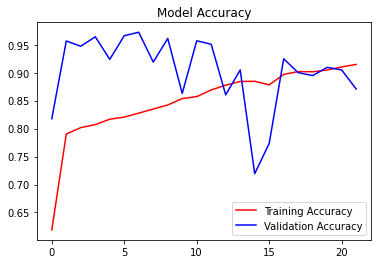

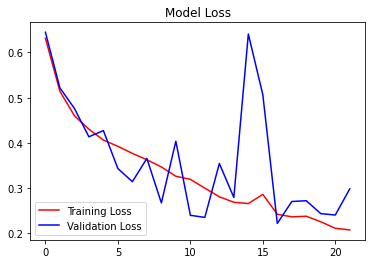

Iteration= 2
Create Model
Found 15618 validated image filenames belonging to 2 classes.
Found 3123 validated image filenames belonging to 2 classes.
Found 15618 validated image filenames belonging to 2 classes.
Found 3123 validated image filenames belonging to 2 classes.
Epoch 1/25
244/244 [==============================] - 487s 2s/step - loss: 0.6368 - accuracy: 0.6139 - val_loss: 0.5937 - val_accuracy: 0.8870
Epoch 2/25
244/244 [==============================] - 409s 2s/step - loss: 0.4697 - accuracy: 0.8077 - val_loss: 0.4709 - val_accuracy: 0.9652
Epoch 3/25
244/244 [==============================] - 416s 2s/step - loss: 0.4317 - accuracy: 0.8124 - val_loss: 0.4483 - val_accuracy: 0.9391
Epoch 4/25
244/244 [==============================] - 408s 2s/step - loss: 0.4101 - accuracy: 0.8165 - val_loss: 0.3779 - val_accuracy: 0.9554
Epoch 5/25
244/244 [==============================] - 408s 2s/step - loss: 0.3859 - accuracy: 0.8299 - val_loss: 0.4078 - val_accuracy: 0.9206
Epoch 6/25
24

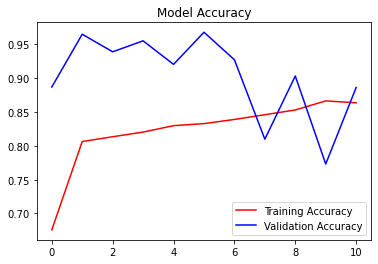

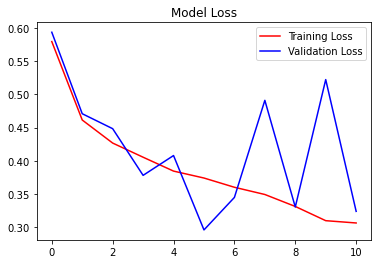

Iteration= 3
Create Model
Found 15620 validated image filenames belonging to 2 classes.
Found 3124 validated image filenames belonging to 2 classes.
Found 15620 validated image filenames belonging to 2 classes.
Found 3124 validated image filenames belonging to 2 classes.
Epoch 1/25
244/244 [==============================] - 412s 2s/step - loss: 0.5692 - accuracy: 0.7065 - val_loss: 0.5040 - val_accuracy: 0.9834
Epoch 2/25
244/244 [==============================] - 408s 2s/step - loss: 0.4469 - accuracy: 0.7972 - val_loss: 0.3922 - val_accuracy: 0.9938
Epoch 3/25
244/244 [==============================] - 404s 2s/step - loss: 0.4210 - accuracy: 0.8073 - val_loss: 0.3620 - val_accuracy: 0.9759
Epoch 4/25
244/244 [==============================] - 403s 2s/step - loss: 0.4092 - accuracy: 0.8095 - val_loss: 0.3350 - val_accuracy: 0.9609
Epoch 5/25
244/244 [==============================] - 404s 2s/step - loss: 0.3906 - accuracy: 0.8211 - val_loss: 0.2889 - val_accuracy: 0.9805
Epoch 6/25
24

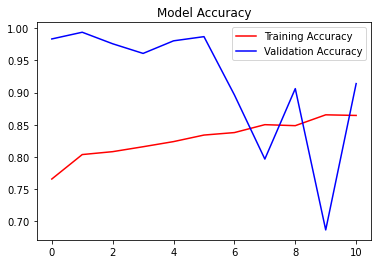

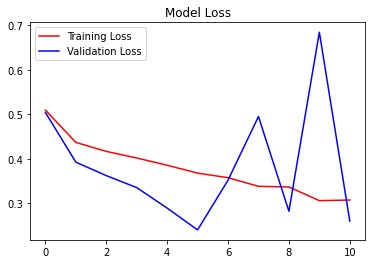

Iteration= 4
Create Model
Found 15618 validated image filenames belonging to 2 classes.
Found 3123 validated image filenames belonging to 2 classes.
Found 15618 validated image filenames belonging to 2 classes.
Found 3123 validated image filenames belonging to 2 classes.
Epoch 1/25
244/244 [==============================] - 413s 2s/step - loss: 0.6847 - accuracy: 0.5559 - val_loss: 0.7005 - val_accuracy: 0.5078
Epoch 2/25
244/244 [==============================] - 406s 2s/step - loss: 0.6342 - accuracy: 0.7293 - val_loss: 0.5882 - val_accuracy: 0.9424
Epoch 3/25
244/244 [==============================] - 404s 2s/step - loss: 0.5457 - accuracy: 0.7962 - val_loss: 0.4761 - val_accuracy: 0.9372
Epoch 4/25
244/244 [==============================] - 403s 2s/step - loss: 0.4702 - accuracy: 0.7962 - val_loss: 0.3401 - val_accuracy: 0.9775
Epoch 5/25
244/244 [==============================] - 404s 2s/step - loss: 0.4209 - accuracy: 0.8145 - val_loss: 0.3509 - val_accuracy: 0.9336
Epoch 6/25
24

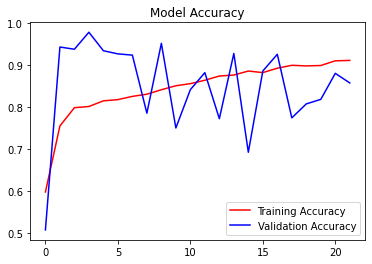

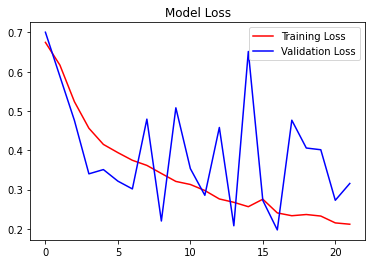

Iteration= 5
Create Model
Found 15618 validated image filenames belonging to 2 classes.
Found 3123 validated image filenames belonging to 2 classes.
Found 15618 validated image filenames belonging to 2 classes.
Found 3123 validated image filenames belonging to 2 classes.
Epoch 1/25
244/244 [==============================] - 407s 2s/step - loss: 0.6707 - accuracy: 0.5349 - val_loss: 0.6514 - val_accuracy: 0.8512
Epoch 2/25
244/244 [==============================] - 392s 2s/step - loss: 0.5149 - accuracy: 0.7950 - val_loss: 0.5334 - val_accuracy: 0.9427
Epoch 3/25
244/244 [==============================] - 394s 2s/step - loss: 0.4573 - accuracy: 0.8097 - val_loss: 0.4888 - val_accuracy: 0.9336
Epoch 4/25
244/244 [==============================] - 393s 2s/step - loss: 0.4319 - accuracy: 0.8068 - val_loss: 0.3966 - val_accuracy: 0.9730
Epoch 5/25
244/244 [==============================] - 402s 2s/step - loss: 0.4051 - accuracy: 0.8260 - val_loss: 0.4115 - val_accuracy: 0.9355
Epoch 6/25
24

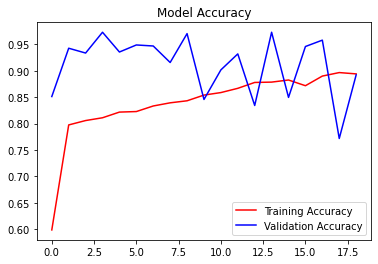

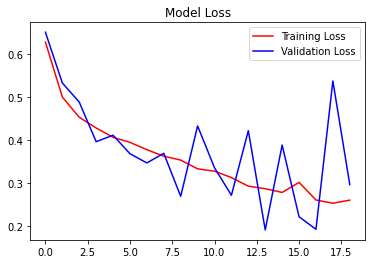

CV_Scores:95.59%(+/- 2.54%)


(95.59244751930237, 2.5359384358373527)

In [18]:
Resnet50_with_cv(train, trainB, height=224, width=224, depth=3, cross_validation=5,
                 optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'], 
                 epochs=25, batch_size=64)

In [19]:
model_test = load_model("best_cv_multi_model.h5")
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testA_generator = data_generator.flow_from_dataframe(dataframe=testA, 
                                                    directory='../Data',
                                                    x_col="filepath",
                                                    y_col='category',
                                                    class_mode='categorical',
                                                    batch_size=64,
                                                    target_size=(224,224))
# testB data generator
testB_generator = data_generator.flow_from_dataframe(dataframe=testB,
                                            directory='../Data',
                                            x_col='filepath',
                                            y_col='category',
                                            batch_size=64,
                                            target_size=(224,224))
# multi-input test data
test_multi_gen=MultiGen(testA_generator, testB_generator)

Found 12796 validated image filenames belonging to 2 classes.
Found 12796 validated image filenames belonging to 2 classes.


In [20]:
# test final model
step_test=testA_generator.n//testA_generator.batch_size
test_score=model_test.evaluate_generator(test_multi_gen, steps=step_test)
print(test_score)

[0.9835105538368225, 0.5081658363342285]
